In [1]:
from fastai.vision import *
from models import Darknet
from train import hyp
from utils import torch_utils
from utils.utils import compute_loss, build_targets

In [2]:
coco = untar_data(URLs.COCO_TINY)
images, lbl_bbox = get_annotations(coco/'train.json')
img2bbox = dict(zip(images, lbl_bbox))
get_y_func = lambda o:img2bbox[o.name]

In [3]:
data = (ObjectItemList.from_folder(coco)
        #Where are the images? -> in coco and its subfolders
        .split_by_rand_pct()                          
        #How to split in train/valid? -> randomly with the default 20% in valid
        .label_from_func(get_y_func)
        #How to find the labels? -> use get_y_func on the file name of the data
        .transform(get_transforms(), tfm_y=True)
        #Data augmentation? -> Standard transforms; also transform the label images
        .databunch(bs=16, collate_fn=bb_pad_collate))   
        #Finally we convert to a DataBunch, use a batch size of 16,
        # and we use bb_pad_collate to collate the data into a mini-batch

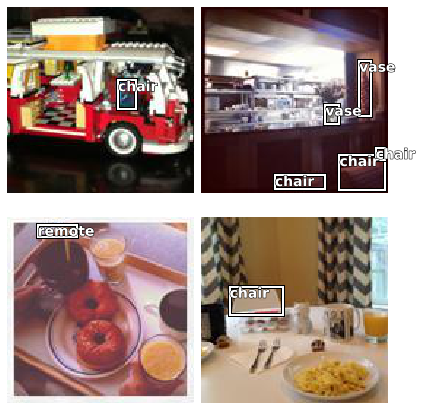

In [4]:
data.show_batch(rows=2, ds_type=DatasetType.Valid, figsize=(6,6))


In [5]:
device = 'cpu'
arc = 'default'
cfg = 'cfg/yolov3-tiny-anchors.cfg'
device = torch_utils.select_device(device, apex=False, batch_size=64)
model = Darknet(cfg, arc=arc).to(device)

Using CPU



In [6]:
def loss_func(predicted, boxes, classes):
    targets = []
    bs = classes.shape[0]
    max_detections = classes.shape[1]
    for img_idx in range(bs):
        for detect_idx in range(max_detections):
            clazz = classes[img_idx, detect_idx]
            if clazz == 0: continue
            x, y, w, h = boxes[img_idx, detect_idx] * 0.5 + 0.5
            targets.append([img_idx, float(clazz), float(x), float(y), float(w), float(h)])
    targets = tensor(targets)
    targets = build_targets(model, targets)
    loss = compute_loss(predicted, targets, model)
    return loss

In [7]:
learner = Learner(data, model, loss_func=loss_func)

In [8]:
model.arc = 'default'
model.nc = 7  # num classes
model.hyp = hyp
learner.fit(1)

epoch,train_loss,valid_loss,time


RuntimeError: expected device cpu but got device cuda:0